In [1]:
# reload modules before running
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import re, sys, types
import numpy as np
import torch
#import torch_struct
#from torch_struct import AlignmentCRF

sys.path.append('../tensormorph')
import config
#from recorder import Recorder
import tpr, tensormorph
from morph import MorphOp, Morph
from birnn_pivoter import *
import distance

import matplotlib.pyplot as plt
print('done')

done


In [4]:
# GRU parameterization
gru1 = torch.nn.GRU(input_size = 2, hidden_size = 3, batch_first = True, bidirectional = True)
for x in gru1.state_dict():
    print(x, gru1.state_dict()[x].shape)

weight_ih_l0 torch.Size([9, 2])
weight_hh_l0 torch.Size([9, 3])
bias_ih_l0 torch.Size([9])
bias_hh_l0 torch.Size([9])
weight_ih_l0_reverse torch.Size([9, 2])
weight_hh_l0_reverse torch.Size([9, 3])
bias_ih_l0_reverse torch.Size([9])
bias_hh_l0_reverse torch.Size([9])


In [5]:
# Batch matrix-vector multiplication
M = torch.randn(10, 6, 4)
v = torch.randn(10, 4)
torch.matmul(M, v.unsqueeze(-1)).shape
#(M @ v.unsqueeze(1)).squeeze(-1)

torch.Size([10, 6, 1])

In [15]:
# Prosodic Morphology violation profiles
pivot = ['⋊', 'C', 'V']
pivot_next = ['⋉', 'C', 'V']
affix_begin = ['C', 'V']
affix_end = ['C', 'V']

def onset(x):
    violn = [x[i]=='V' and x[i-1]!='C' for i in range(1,len(x))]
    return np.sum(violn)

def nocoda(x):
    violn = [x[i]=='C' and x[i+1]!='V' for i in range(len(x)-1)]
    return np.sum(violn)

inpt = [x+y for x in pivot for y in pivot_next]
inpt_violn = [(x, onset(x), nocoda(x)) for x in inpt]
print(inpt_violn)

outpt = {x: [x[0]+y+z+x[1]] for x in inpt for y in affix_begin for z in affix_end}
print(outpt)

[('⋊⋉', 0, 0), ('⋊C', 0, 0), ('⋊V', 1, 0), ('C⋉', 0, 1), ('CC', 0, 1), ('CV', 0, 0), ('V⋉', 0, 0), ('VC', 0, 0), ('VV', 1, 0)]
{'⋊⋉': ['⋊VV⋉'], '⋊C': ['⋊VVC'], '⋊V': ['⋊VVV'], 'C⋉': ['CVV⋉'], 'CC': ['CVVC'], 'CV': ['CVVV'], 'V⋉': ['VVV⋉'], 'VC': ['VVVC'], 'VV': ['VVVV']}


In [8]:
args = types.SimpleNamespace()
args.data = 'chamorro/chamorro_um'
args.features = 'hayes_features'
args.reduplication = False
args.global_config = '../global_config.yaml'
tensormorph.init(args)
form_embedder = config.form_embedder
decoder = config.decoder
print(config.ftrs)


train: 145| val: 1| test: 49
segments: ['a', 'b', 'c', 'd', 'dz', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'ts', 'u', 'z', 'ŋ', 'ʔ']
vowels: ['i', 'e', 'a', 'o', 'u']
max_len: 20
['ε', '⋊', '⋉', 'a', 'o', 'e', 'u', 'i', 'ŋ', 'r', 'n', 'm', 'l', 'ʔ', 'c', 'k', 'g', 'z', 't', 's', 'p', 'f', 'd', 'b', 'dz', 'ts', 'h'] 27
['a', 'o', 'e', 'u', 'i']
['sym', 'begin/end', 'C/V', 'syllabic', 'consonantal', 'sonorant', 'continuant', 'delayed.release', 'approximant', 'trill', 'nasal', 'voice', 'spread.gl', 'constr.gl', 'LABIAL', 'round', 'labiodental', 'CORONAL', 'anterior', 'distributed', 'strident', 'lateral', 'DORSAL', 'high', 'low', 'front', 'back', 'tense']
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  

['⋊ d a ŋ k u l u ⋉'] -> ['⋊ d u m a ŋ k u l u ⋉']


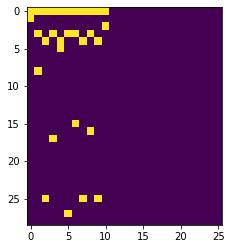

In [28]:
stem_str = ['d a ŋ k u l u']
output_str = ['d u m a ŋ k u l u']
stem_str = form_embedder.string2delim(stem_str, split=False)
output_str = form_embedder.string2delim(output_str, split=False)
stem = Morph(form_str = stem_str)
output = Morph(form_str = output_str)
print(stem.form_str, '->', output.form_str)
plt.imshow(output.form[0])

['⋊ d a ŋ k u l u ⋉'] -> ['⋊ d u m a ŋ k u l u ⋉']


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

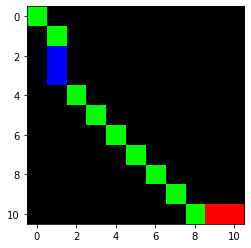

In [21]:
nbatch = stem.form.shape[0]
lengths = torch.tensor([stem.length[0], output.length[0]])
max_len = max(lengths.numpy())
dist = distance.sqeuclid_batch(stem.form, output.form[0])
log_potentials = -1.0 * torch.ones((nbatch, config.nrole, config.nrole, 3))
log_potentials[0,:,:,1] = -dist # cost of diagonal
log_potentials = log_potentials[:,:max_len,:,:]
log_potentials = log_potentials[:,:,:max_len,:]

plt.imshow(log_potentials[0,:,:,1])
distrib = torch_struct.AlignmentCRF(log_potentials) #, local=True, max_gap=1
best = distrib.argmax
#print(best[0])
plt.imshow(best[0])
plt.imshow(distrib.marginals[0])
samp = distrib.sample(sample_shape = (1,))
#plt.imshow(dist.sample(sample_shape=(1,))[0])

In [29]:
# Example of rule extraction from alignments
import edlib

# 1. Align stem and output
input_str = stem_str[0].replace(' ', '')
output_str = output_str[0].replace(' ', '')
result = edlib.align(input_str, output_str, task = "path")
nice = edlib.getNiceAlignment(result, input_str, output_str)
nice = '\n'.join(nice.values())
print(nice)

# 2. Extract affix material from alignmnent
# 3. Identify candidate pivot points for affixation
# 4. Accumulate over examples, resolving indeterminacies

⋊d--aŋkulu⋉
||--|||||||
⋊dumaŋkulu⋉
